In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_histogram(attention_scores, layer_num):
    # Flatten the attention scores to a single list
    attention_values = [score.item() for scores in attention_scores for score in scores.flatten()]
    plt.figure(figsize=(10, 6))
    plt.hist(attention_values, bins=50, alpha=0.75)
    plt.title(f'Attention Score Distribution - Layer {layer_num}')
    plt.xlabel('Attention Scores')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_attention_piechart(attention_scores, layer_num):
    # Flatten the attention scores to a single list
    attention_values = [score.item() for scores in attention_scores for score in scores.flatten()]
    
    # Calculate histogram data
    hist, bin_edges = np.histogram(attention_values, bins=50)
    
    # Calculate percentage of each bin
    percentages = hist / hist.sum() * 100
    
    # Create pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(percentages, labels=[f'{edge:.2f}-{bin_edges[i+1]:.2f}' for i, edge in enumerate(bin_edges[:-1])], autopct='%1.1f%%')
    plt.title(f'Attention Score Distribution - Layer {layer_num}')
    plt.show()


/Users/dankur/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenizer_config.json: 100%|██████████| 51.1k/51.1k [00:00<00:00, 53.0MB/s]
tokenizer.json: 100%|██████████| 9.08M/9.08M [00:00<00:00, 21.6MB/s]
special_tokens_map.json: 100%|██████████| 73.0/73.0 [00:00<00:00, 549kB/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
config.json: 100%|██████████| 654/654 [00:00<00:00, 7.68MB/s]
model.safetensors.index.json: 100%|██████████| 23.9k/23.9k [00:00<00:00, 79.0MB/s]
model-00001-of-00004.safetensors: 100%|██████████| 4.98G/4.98G [01:16<00:00, 64.8MB/s]
model-00002-of-00004.safetensors: 100%|██████████| 5.00G/5.00G [01:12<00:00, 68.8MB/s]
model-00003-of-00004.safetensors: 100%|██████████| 4.92G/4.92G [01:09<00:00, 71.0MB/s]
model-00004-of-00004.safetensors: 100%|██████████| 1.17G/1.17G [00:16<00:00, 72.5MB/s]
generation_config.json: 100%|██████████| 126/126 [00:00<00:00, 436kB/s]
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` do

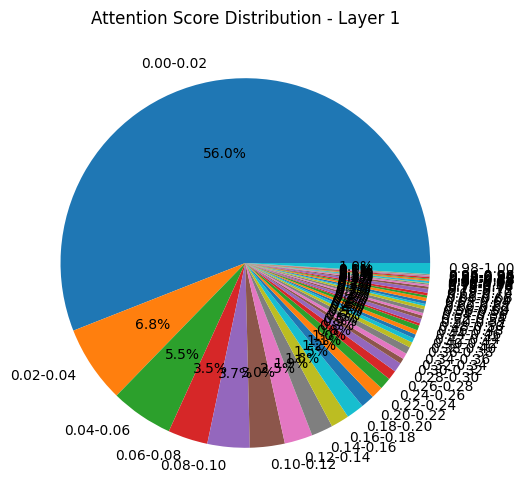

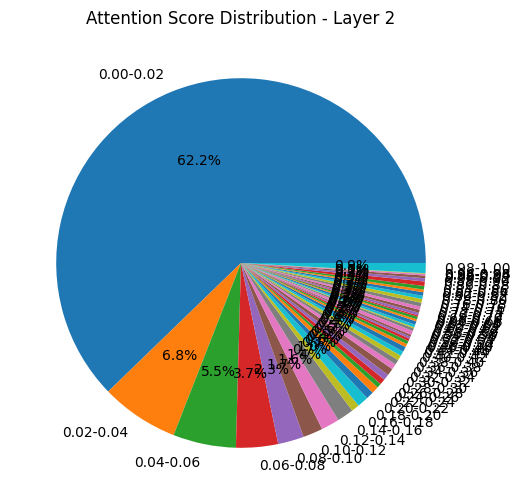

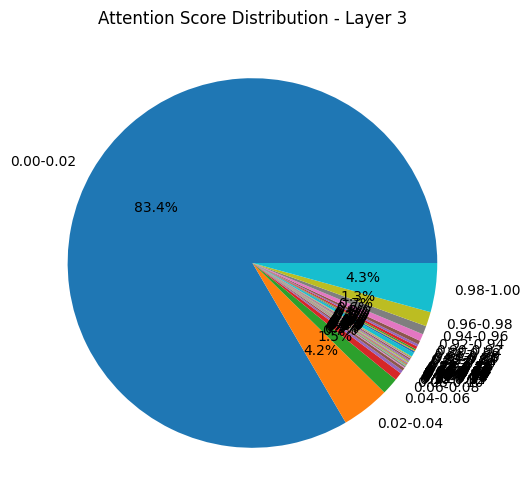

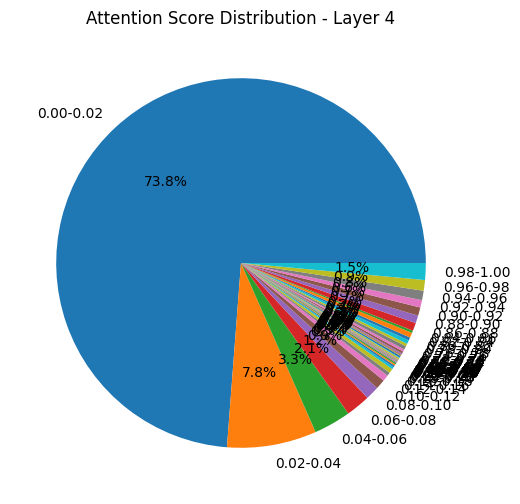

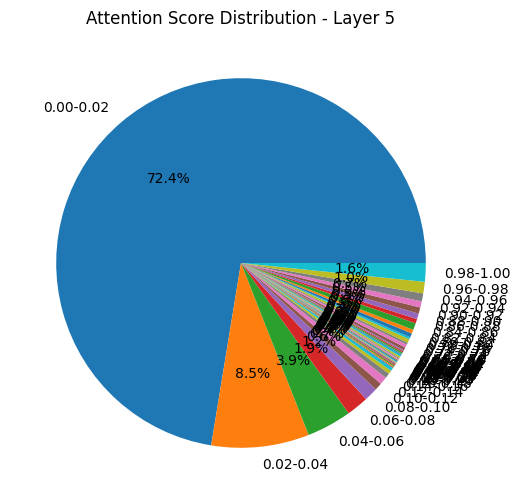

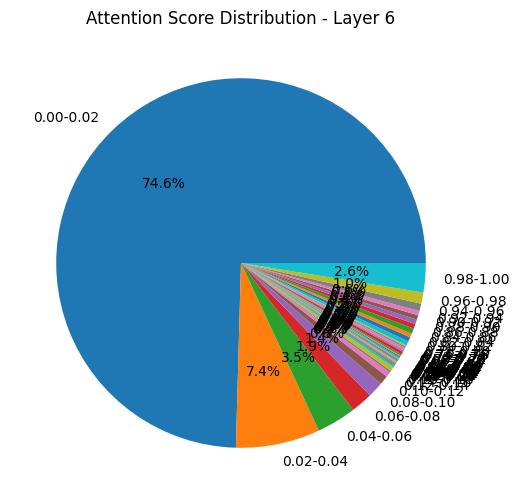

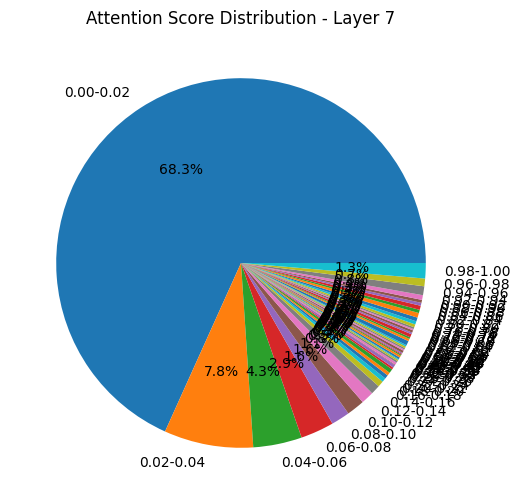

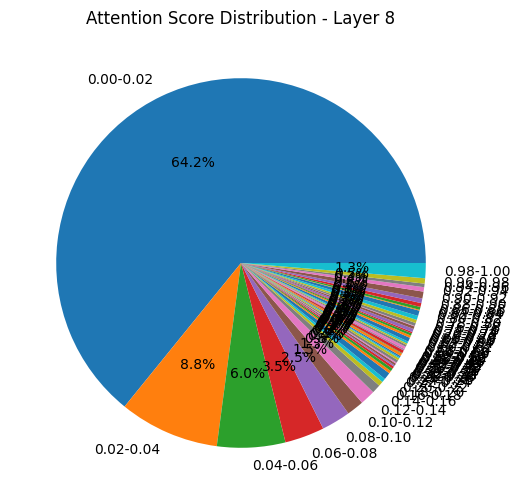

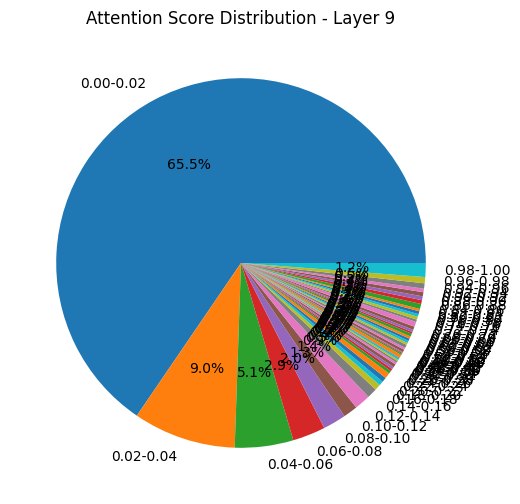

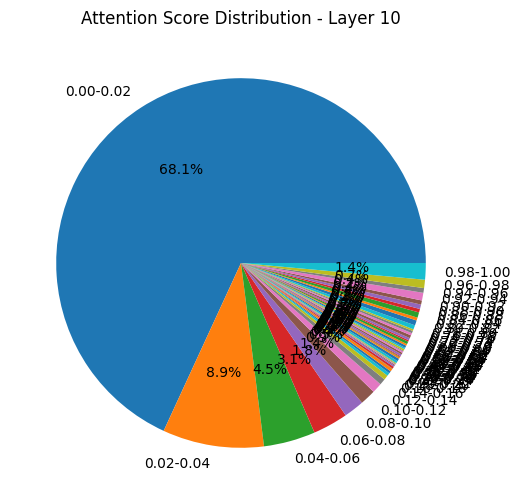

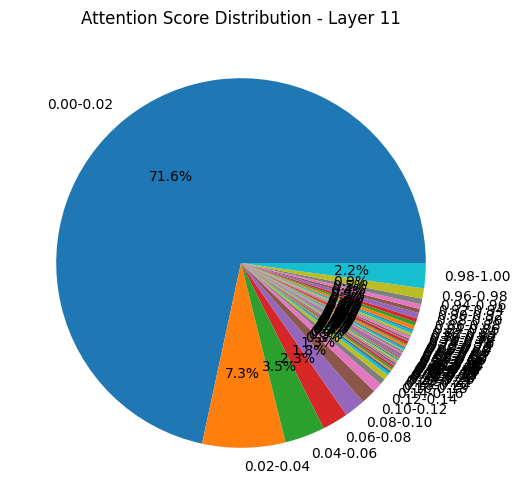

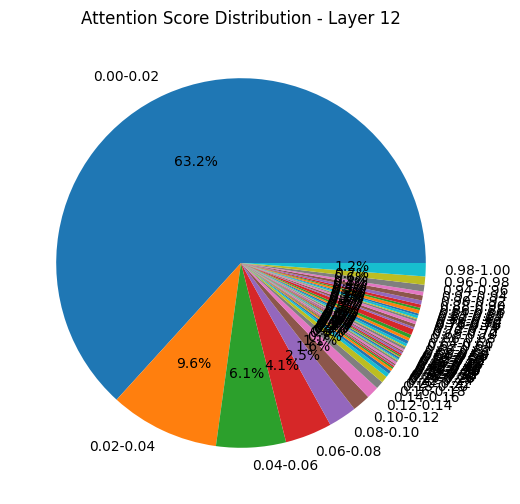

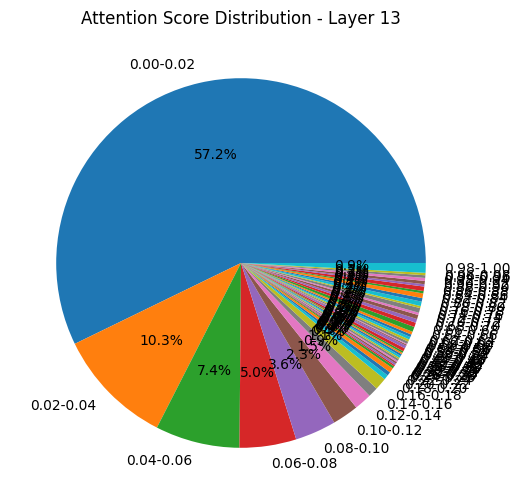

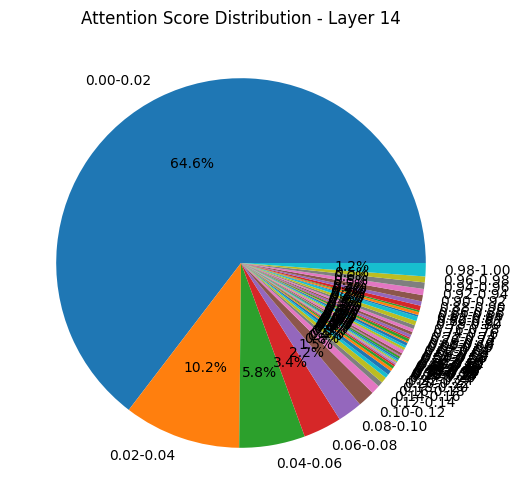

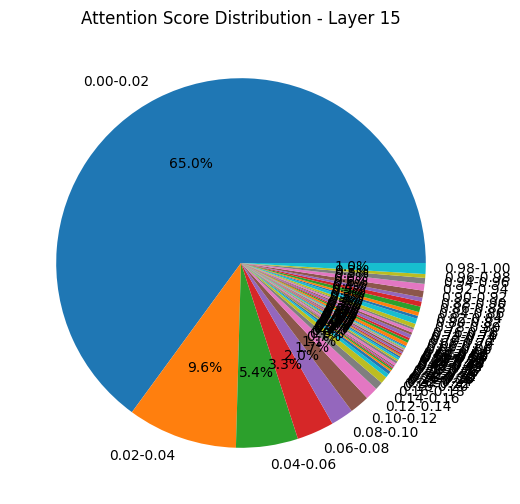

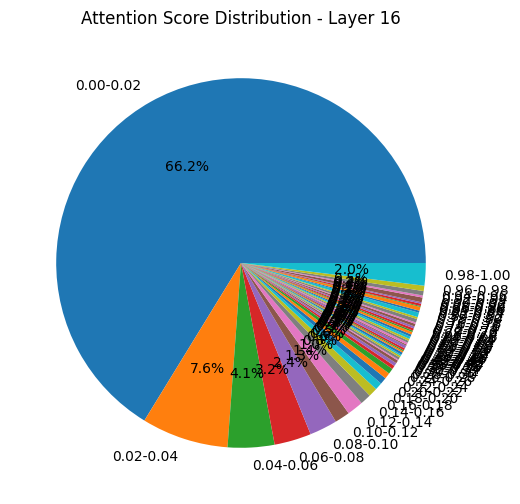

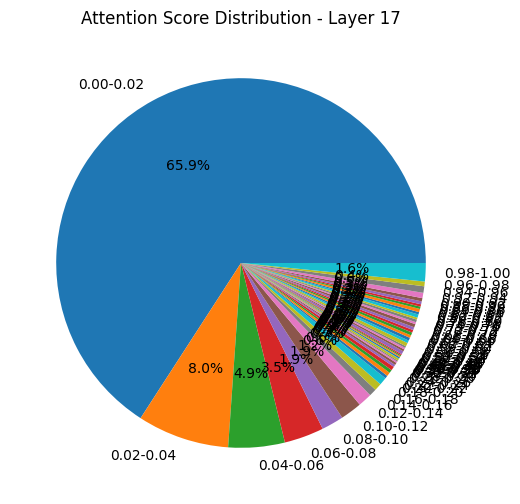

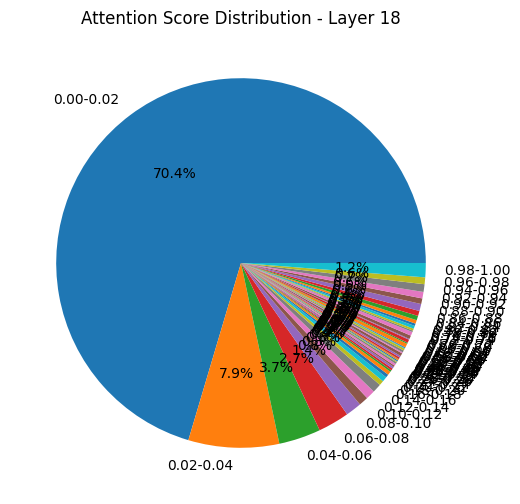

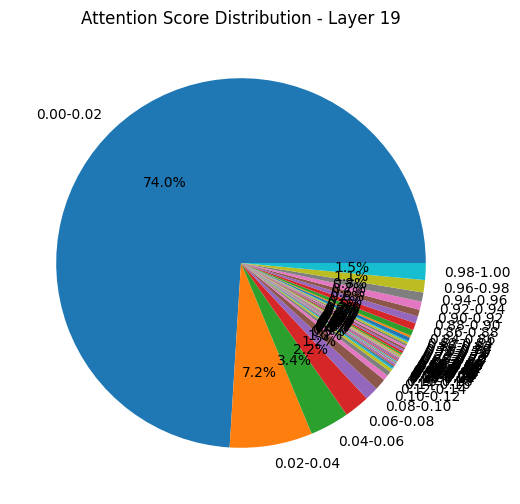

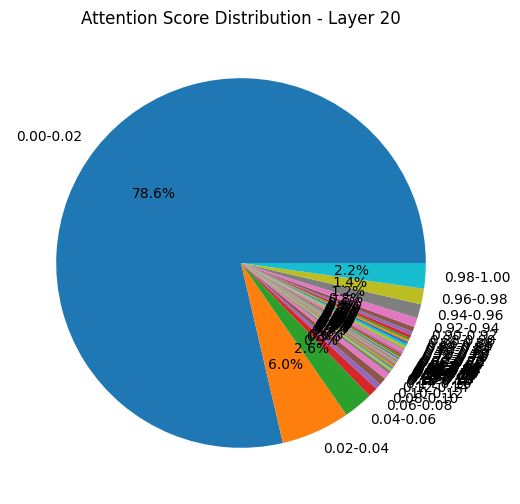

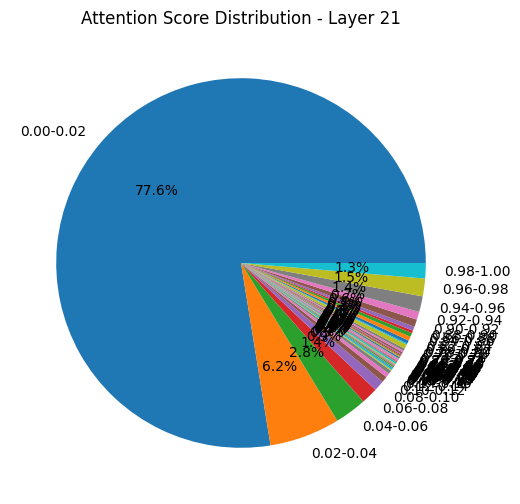

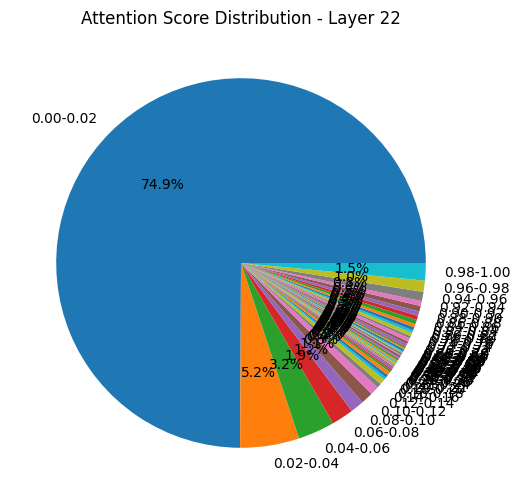

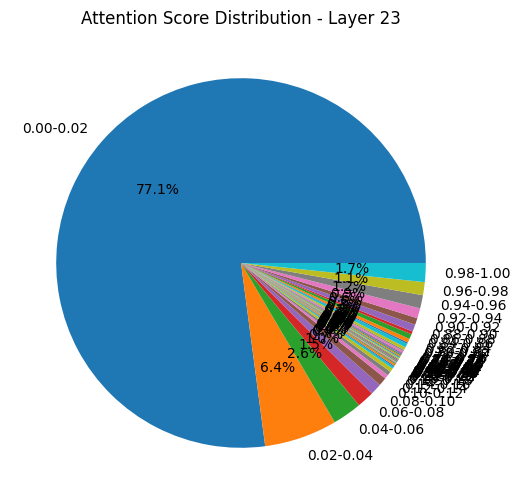

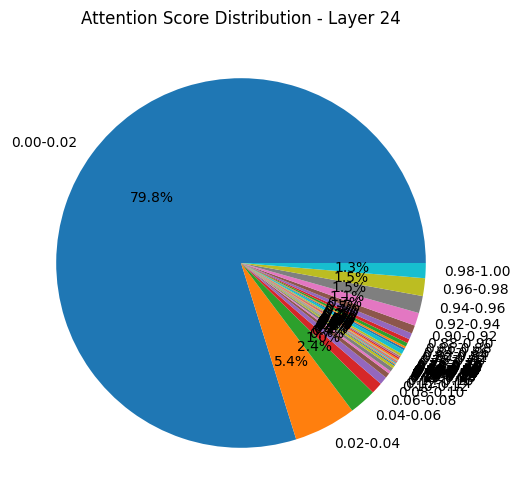

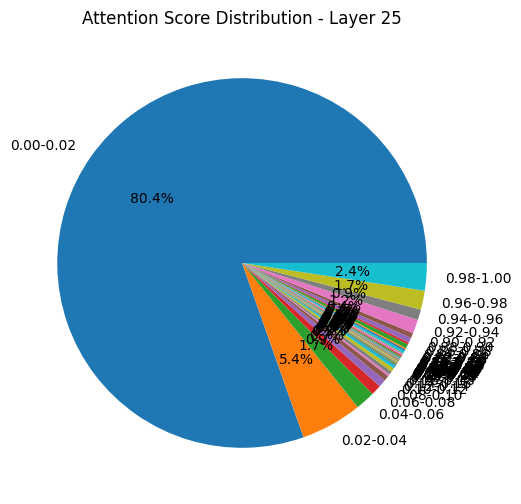

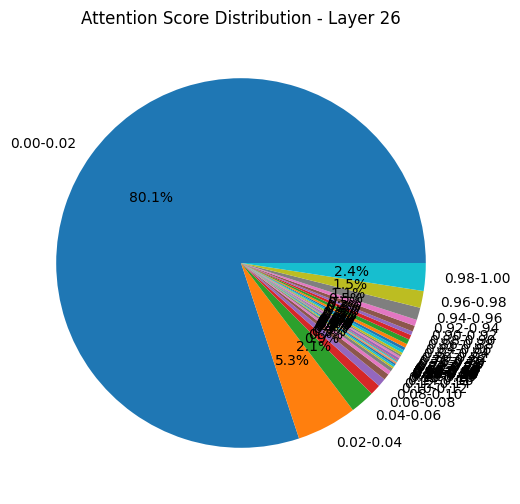

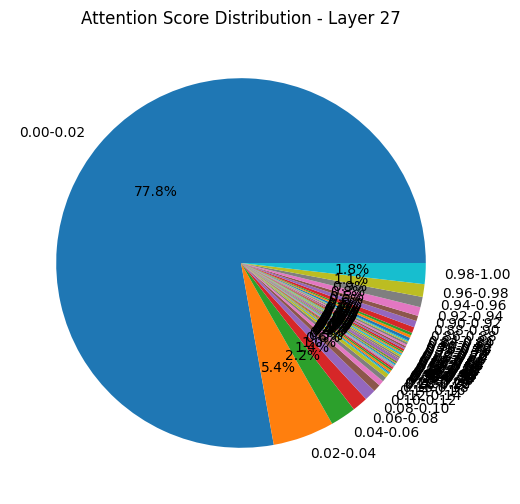

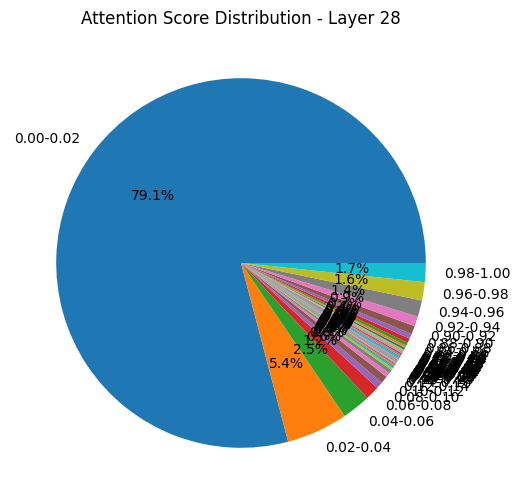

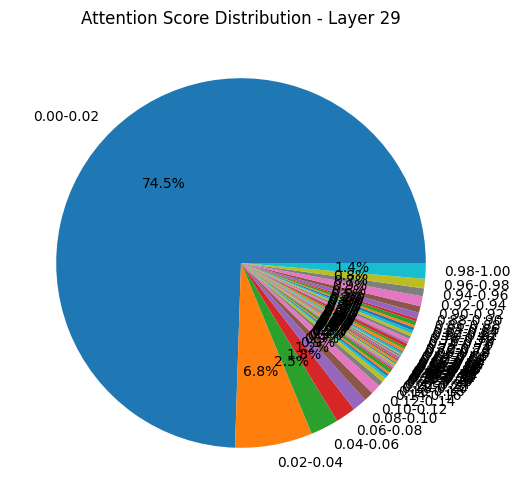

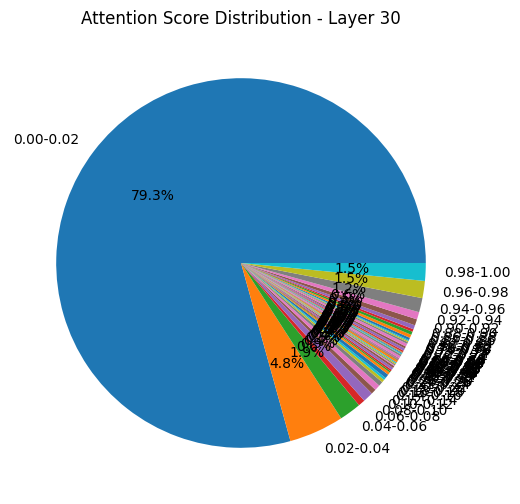

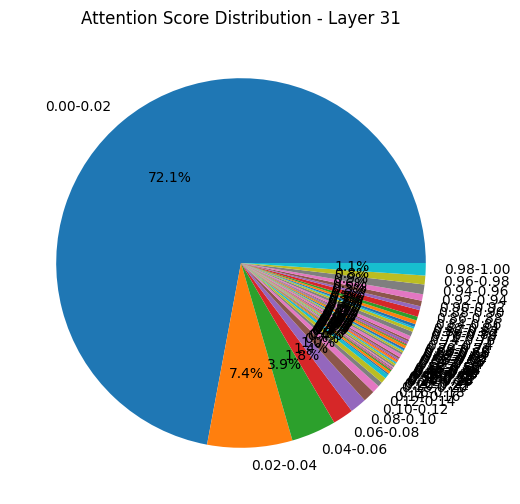

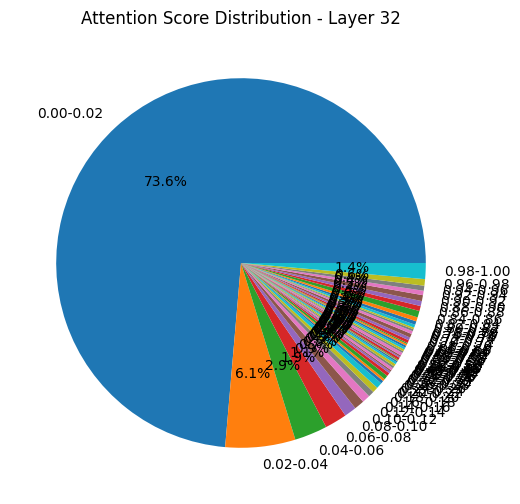

In [3]:
# Load tokenizer and model
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"  # Example model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)

# Encode input and create tensors
input_text = "Here is some text to decode using the transformer model."  # Example input
inputs = tokenizer(input_text, return_tensors="pt")

# Run the model
with torch.no_grad():
    outputs = model(**inputs)

# Get the attentions
attentions = outputs.attentions  # Tuple of tensors: one for each layer

# Process each layer's attention scores
for i, layer_attention in enumerate(attentions):
    # layer_attention is of shape [batch_size, num_heads, sequence_length, sequence_length]
    # For histogram, we consider all heads and all positions
    # plot_attention_histogram(layer_attention[0], i + 1)
    plot_attention_piechart(layer_attention[0], i + 1)
    # only plotting the first batch

